In [2]:
# from sklearn.preprocessing import PolynomialFeatures
import numpy as np
# import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial
# import randcbpside
# import randcbpside2
import games 
# import random
import math
# import pandas as pd
import synthetic_data


class Evaluation_contextual:

    def __init__(self, horizon ):

        self.horizon = horizon

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):#jobid
        context_generator, seed = job
        np.random.seed(seed)
        alg.reset()

        cumRegret =  np.zeros(self.horizon, dtype =float)
        actions = np.zeros(self.horizon, dtype =float)
        alg.reset()

        for t in range(self.horizon):
            print(t)
            context, distribution = context_generator.get_context(False)
            # distribution = context_generator.get_distribution(context)
            outcome = np.random.choice( 2 , p = distribution )
            # outcome = 0 if distribution[0]<0.5 else 1

            action = alg.get_action(t, context)
            
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, context )

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )
            # print(i_star)
            # print()

            # regret = game.LossMatrix[action, outcome] - np.min( game.LossMatrix[...,outcome] )

            cumRegret[t] =  val
            actions[t] = action

        return  np.cumsum( cumRegret ) 

In [3]:
dim = 3
horizon = 7500
# nfolds = 10
game = games.apple_tasting(False)
import randcbpside2
import PGTS
import PGIDSratio


class LinearContexts:
    def __init__(self, w):
        self.d = len(w) #number of features
        self.w = w
        self.type = 'linear'
        self.normalize()

    def normalize(self,):
        all = []
        for _ in range(100000):
            c,d = self.get_context(False)
            all.append( c )
        all = np.array(all)
        self.mean = np.mean(all,0)
        self.std = np.std(all,0 )

    def get_context(self, normalize):
        context = np.random.uniform(0, 1,  self.d )
        context = np.array(context).reshape(self.d,1)
        val = self.w @ context
        distribution = [ val[0], 1-val[0] ]
        if normalize:
            context = ( context - self.mean ) / self.std
        return context, distribution
    
    # def get_distribution(self,cont):
    #     
    #     return 

dim = 10
w = np.random.uniform(0, 0.1, 10)
w = w / w.sum()
context_generator = LinearContexts( w ) 

alg = PGTS.PGTS(game, dim,)
# alg = PGIDSratio.PGIDSratio(game, dim,)
# alg = randcbpside2.RandCPBside(game, dim, 1.01, 0.05, 1, 10, 10e-7)

eval = Evaluation_contextual(horizon)

res = eval.eval_policy_once(alg, game, [ context_generator , 0  ] )

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

: 

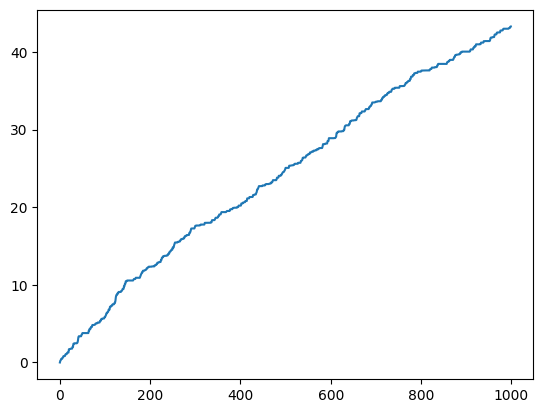

In [20]:
import matplotlib.pyplot as plt
plt.plot( range(horizon), res, label = 'randcbpside' )

In [22]:


dim = 10
w = np.random.uniform(0, 0.1, 10)
w = w / w.sum()
context_generator = LinearContexts( w ) 

all = []
for _ in range(100000):
    c = context_generator.get_context(True)
    all.append( c )

all = np.array(all)


res3

In [2]:
import numpy as np

class Evaluation:

    def __init__(self, horizon,task):
        self.task = task
        self.horizon = horizon

    def get_outcomes(self, game):
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        alg.reset()
        distribution, jobid, label, nfolds = job
        np.random.seed(jobid)

        outcome_distribution =  {'spam':distribution[0], 'ham':distribution[1]}

        game.set_outcome_distribution( outcome_distribution , jobid )

        action_counter = np.zeros( (game.n_actions, self.horizon) )

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game )

        for t in range(self.horizon):
            #print(t)

            # Environment chooses one outcome and one context associated to this outcome
            outcome = outcomes[t]

            # policy chooses one action
            # print('t', t,  'outcome', outcome, 'context', context)
            action = alg.get_action(t)

            print('t', t, 'action', action, 'outcome', outcome, )
            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, None )

            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] +1
                else:
                    action_counter[i][t] = action_counter[i][t-1]
            
            result = np.array( [ game.delta(i) for i in range(game.n_actions) ]).T @ action_counter

        return  result 


eval = Evaluation(500, 'imbalanced', )
import randcbp
import games
game = games.apple_tasting(False)
alg = randcbp.RandCBP(game,1.01,1/8,10,10e-7)
job = [0.15,1-0.15], 0, None, None
eval.eval_policy_once(alg,game,job)

t 0 action 0 outcome 1
t 1 action 1 outcome 1
rhos [0.0, 0.09296744766583921, 0.18593489533167842, 0.27890234299751765, 0.37186979066335685, 0.46483723832919605, 0.5578046859950353, 0.6507721336608745, 0.7437395813267137, 0.8367070289925529]
0.18593489533167842
t 2 action 0 outcome 1
rhos [0.0, 0.11704164140024731, 0.23408328280049462, 0.35112492420074193, 0.46816656560098924, 0.5852082070012365, 0.7022498484014839, 0.8192914898017312, 0.9363331312019785, 1.0533747726022258]
0.23408328280049462
t 3 action 0 outcome 1
rhos [0.0, 0.13147582534824076, 0.2629516506964815, 0.3944274760447223, 0.525903301392963, 0.6573791267412038, 0.7888549520894446, 0.9203307774376853, 1.051806602785926, 1.1832824281341667]
0.525903301392963
t 4 action 0 outcome 1
rhos [0.0, 0.1416626270255611, 0.2833252540511222, 0.4249878810766833, 0.5666505081022444, 0.7083131351278055, 0.8499757621533666, 0.9916383891789277, 1.1333010162044888, 1.2749636432300497]
0.8499757621533666
t 5 action 0 outcome 1
rhos [0.0, 0.

array([0. , 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
       1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
       1.4, 1.4, 1.4, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1,
       2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1,
       2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8,
       2.8, 2.8, 2.8, 2.8, 2.8, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5,
       3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.